In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import seaborn
seaborn.set_theme(style="whitegrid")
seaborn.set_context("poster")

In [2]:
data = pd.read_csv("../data/rol_measurements_calibration.csv")

In [3]:
data

,code,location,start_date,end_date,no2,period,no2_reference,missing
0,34-37,VMM Groenenborger,2021-01-29 18:42:00+01:00,2021-02-26 13:41:00+01:00,21,2,24.241911,2.698651
1,34-39,VMM Groenenborger,2021-01-29 18:42:00+01:00,2021-02-26 13:41:00+01:00,21,2,24.241911,2.698651
2,34-19,VMM Belgiëlei,2021-01-29 13:48:00+01:00,2021-02-26 20:01:00+01:00,29,2,31.017345,2.356406
3,34-20,VMM Belgiëlei,2021-01-29 13:48:00+01:00,2021-02-26 20:01:00+01:00,30,2,31.017345,2.356406
4,35-47,VMM Groenenborger,2021-02-26 13:41:00+01:00,2021-03-27 12:55:00+01:00,23,3,27.132979,18.848921
5,35-48,VMM Groenenborger,2021-02-26 13:41:00+01:00,2021-03-27 12:55:00+01:00,24,3,27.132979,18.848921
6,35-19,VMM Belgiëlei,2021-02-26 20:01:00+01:00,2021-03-26 15:43:00+01:00,34,3,33.081413,2.398801
7,35-20,VMM Belgiëlei,2021-02-26 20:01:00+01:00,2021-03-26 15:43:00+01:00,33,3,33.081413,2.398801
8,36-47,VMM Groenenborger,2021-03-27 12:55:00+01:00,2021-04-23 12:03:00+02:00,22,4,24.774760,3.245750
9,36-48,VMM Groenenborger,2021-03-27 12:55:00+01:00,2021-04-23 12:03:00+02:00,22,4,24.774760,3.245750


In [4]:
def overview_comparison(data):
    meas = data["no2"]
    ref = data["no2_reference"]
    
    print(f"Bias: {meas.mean() - ref.mean():.2f} µg/m³")
    print(f"MAD:   {(meas - ref).abs().mean():.2f} µg/m³")

In [5]:
overview_comparison(data)

Bias: -1.74 µg/m³
MAD:   2.51 µg/m³


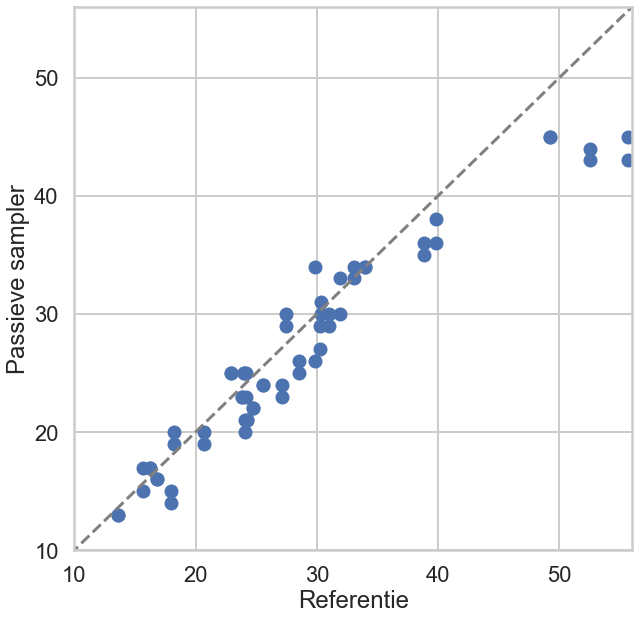

In [6]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(data["no2_reference"], data["no2"])
ax.plot([0, 56], [0, 56], color="grey", linestyle="--")
ax.set(xlim=(10, 56), ylim=(10, 56), xlabel="Referentie", ylabel="Passieve sampler");

In [7]:
data2 = data[data["missing"] < 25]

In [8]:
overview_comparison(data2)

Bias: -1.03 µg/m³
MAD:   1.77 µg/m³


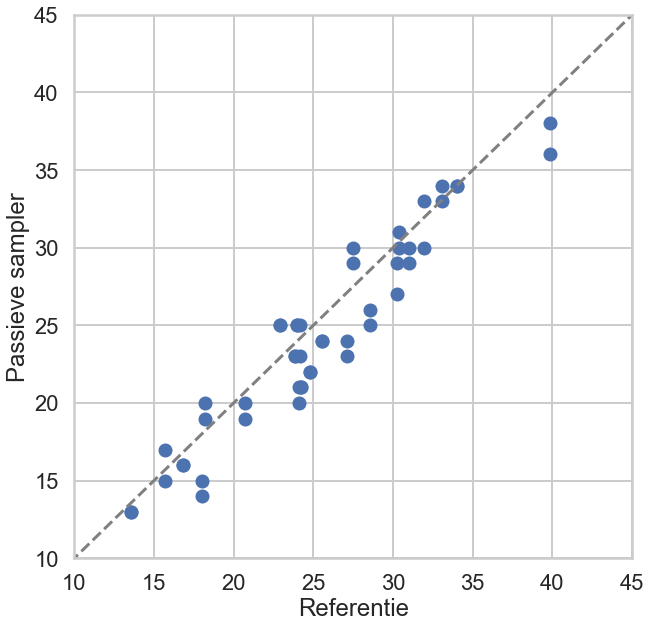

In [9]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(data2["no2_reference"], data2["no2"])
ax.plot([0, 45], [0, 45], color="grey", linestyle="--")
ax.set(xlim=(10, 45), ylim=(10, 45), xlabel="Referentie", ylabel="Passieve sampler");

In [10]:
data3 = data[data["location"] != "Van Maerlant"]

In [11]:
overview_comparison(data3)

Bias: -0.89 µg/m³
MAD:   1.68 µg/m³


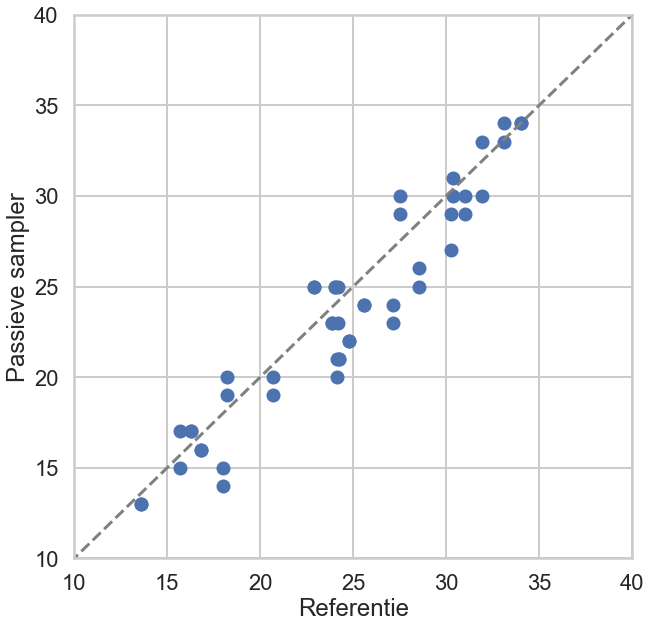

In [12]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(data3["no2_reference"], data3["no2"])
ax.plot([0, 40], [0, 40], color="grey", linestyle="--")
ax.set(xlim=(10, 40), ylim=(10, 40), xlabel="Referentie", ylabel="Passieve sampler");

In [13]:
import statsmodels.formula.api as smf

In [14]:
mod = smf.ols('no2 ~ no2_reference - 1', data=data2).fit()

In [15]:
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    no2   R-squared (uncentered):                   0.995
Model:                            OLS   Adj. R-squared (uncentered):              0.995
Method:                 Least Squares   F-statistic:                              8821.
Date:                Tue, 07 Jun 2022   Prob (F-statistic):                    3.84e-55
Time:                        12:19:31   Log-Likelihood:                         -97.224
No. Observations:                  48   AIC:                                      196.4
Df Residuals:                      47   BIC:                                      198.3
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
no2_reference     0.9597      0.010     93.922      0.000       0.939       0.980
==============================================================================
Omnibus:                        5.295   Durbin-Watson:                   1.298
Prob(Omnibus):                  0.071   Jarque-Bera (JB):                2.072
Skew:                           0.050   Prob(JB):                        0.355
Kurtosis:                       1.987   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [16]:
1 / mod.params["no2_reference"]

1.0420430759265837

In [18]:
mod = smf.ols('no2 ~ no2_reference', data=data2).fit()

In [19]:
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    no2   R-squared:                       0.915
Model:                            OLS   Adj. R-squared:                  0.913
Method:                 Least Squares   F-statistic:                     495.3
Date:                Tue, 07 Jun 2022   Prob (F-statistic):           2.89e-26
Time:                        12:19:46   Log-Likelihood:                -97.215
No. Observations:                  48   AIC:                             198.4
Df Residuals:                      46   BIC:                             202.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.1461      1.135     -0.129      0.898      -2.432       2.139
no2_reference     0.9651      0.043     22.256      0.000       0.878       1.052
==============================================================================
Omnibus:                        5.354   Durbin-Watson:                   1.284
Prob(Omnibus):                  0.069   Jarque-Bera (JB):                2.083
Skew:                           0.050   Prob(JB):                        0.353
Kurtosis:                       1.984   Cond. No.                         110.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [20]:
1 / mod.params["no2_reference"]

1.0361906147744024

In [22]:
-mod.params["Intercept"]

0.14612226956828867